# DiT

In [1]:
# !git clone https://github.com/facebookresearch/DiT.git
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
# !pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

In [2]:
image_size = 256
vae_model = "stabilityai/sd-vae-ft-ema"
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

/content/DiT/download.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(local_path, map_location=lambda storage, loc: storage)
/usr/local/lib/python3.1

torch.Size([1, 4, 32, 32])


<ipython-input-3-c067530514dc>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z = torch.load("starting_noise.pt")[0].unsqueeze(0)


  0%|          | 0/250 [00:00<?, ?it/s]

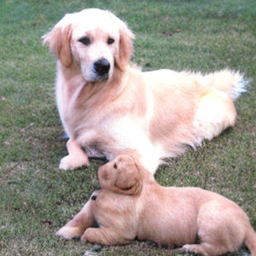

In [3]:
seed = 0
torch.manual_seed(seed)
num_sampling_steps = 250
cfg_scale = 4
class_labels = [207]
samples_per_row = 1

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
z = torch.load("starting_noise.pt")[0].unsqueeze(0)
print(z.shape)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
intermediate_samples = list(diffusion.p_sample_loop_progressive(
    model.forward_with_cfg, z.shape, z, clip_denoised=False,
    model_kwargs=model_kwargs, progress=True, device=device
))
samples = intermediate_samples[-1]['sample']
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row),
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [10]:
epsilons = [x['sample'] for x in intermediate_samples]
epsilons = torch.stack(epsilons)[:, :1]
torch.save(
    epsilons,
    'dit_epsilons.pt'
)

In [13]:
import torch as th
import numpy as np
from functools import partial

def expand_t_like_x(t, x):
    """Function to reshape time t to broadcastable dimension of x
    Args:
      t: [batch_dim,], time vector
      x: [batch_dim,...], data point
    """
    dims = [1] * (len(x.size()) - 1)
    t = t.view(t.size(0), *dims)
    return t


#################### Coupling Plans ####################

class ICPlan:
    """Linear Coupling Plan"""
    def __init__(self, sigma=0.0):
        self.sigma = sigma

    def compute_alpha_t(self, t):
        """Compute the data coefficient along the path"""
        return t, 1

    def compute_sigma_t(self, t):
        """Compute the noise coefficient along the path"""
        return 1 - t, -1

    def compute_d_alpha_alpha_ratio_t(self, t):
        """Compute the ratio between d_alpha and alpha"""
        return 1 / t

    def compute_drift(self, x, t):
        """We always output sde according to score parametrization; """
        t = expand_t_like_x(t, x)
        alpha_ratio = self.compute_d_alpha_alpha_ratio_t(t)
        sigma_t, d_sigma_t = self.compute_sigma_t(t)
        drift = alpha_ratio * x
        diffusion = alpha_ratio * (sigma_t ** 2) - sigma_t * d_sigma_t

        return -drift, diffusion

    def compute_diffusion(self, x, t, form="constant", norm=1.0):
        """Compute the diffusion term of the SDE
        Args:
          x: [batch_dim, ...], data point
          t: [batch_dim,], time vector
          form: str, form of the diffusion term
          norm: float, norm of the diffusion term
        """
        t = expand_t_like_x(t, x)
        choices = {
            "constant": norm,
            "SBDM": norm * self.compute_drift(x, t)[1],
            "sigma": norm * self.compute_sigma_t(t)[0],
            "linear": norm * (1 - t),
            "decreasing": 0.25 * (norm * th.cos(np.pi * t) + 1) ** 2,
            "inccreasing-decreasing": norm * th.sin(np.pi * t) ** 2,
        }

        try:
            diffusion = choices[form]
        except KeyError:
            raise NotImplementedError(f"Diffusion form {form} not implemented")

        return diffusion

    def get_score_from_velocity(self, velocity, x, t):
        """Wrapper function: transfrom velocity prediction model to score
        Args:
            velocity: [batch_dim, ...] shaped tensor; velocity model output
            x: [batch_dim, ...] shaped tensor; x_t data point
            t: [batch_dim,] time tensor
        """
        t = expand_t_like_x(t, x)
        alpha_t, d_alpha_t = self.compute_alpha_t(t)
        sigma_t, d_sigma_t = self.compute_sigma_t(t)
        mean = x
        reverse_alpha_ratio = alpha_t / d_alpha_t
        var = sigma_t**2 - reverse_alpha_ratio * d_sigma_t * sigma_t
        score = (reverse_alpha_ratio * velocity - mean) / var
        return score

    def get_noise_from_velocity(self, velocity, x, t):
        """Wrapper function: transfrom velocity prediction model to denoiser
        Args:
            velocity: [batch_dim, ...] shaped tensor; velocity model output
            x: [batch_dim, ...] shaped tensor; x_t data point
            t: [batch_dim,] time tensor
        """
        t = expand_t_like_x(t, x)
        alpha_t, d_alpha_t = self.compute_alpha_t(t)
        sigma_t, d_sigma_t = self.compute_sigma_t(t)
        mean = x
        reverse_alpha_ratio = alpha_t / d_alpha_t
        var = reverse_alpha_ratio * d_sigma_t - sigma_t
        noise = (reverse_alpha_ratio * velocity - mean) / var
        return noise

    def get_velocity_from_score(self, score, x, t):
        """Wrapper function: transfrom score prediction model to velocity
        Args:
            score: [batch_dim, ...] shaped tensor; score model output
            x: [batch_dim, ...] shaped tensor; x_t data point
            t: [batch_dim,] time tensor
        """
        t = expand_t_like_x(t, x)
        drift, var = self.compute_drift(x, t)
        velocity = var * score - drift
        return velocity

    def compute_mu_t(self, t, x0, x1):
        """Compute the mean of time-dependent density p_t"""
        t = expand_t_like_x(t, x1)
        alpha_t, _ = self.compute_alpha_t(t)
        sigma_t, _ = self.compute_sigma_t(t)
        return alpha_t * x1 + sigma_t * x0

    def compute_xt(self, t, x0, x1):
        """Sample xt from time-dependent density p_t; rng is required"""
        xt = self.compute_mu_t(t, x0, x1)
        return xt

    def compute_ut(self, t, x0, x1, xt):
        """Compute the vector field corresponding to p_t"""
        t = expand_t_like_x(t, x1)
        _, d_alpha_t = self.compute_alpha_t(t)
        _, d_sigma_t = self.compute_sigma_t(t)
        return d_alpha_t * x1 + d_sigma_t * x0

    def plan(self, t, x0, x1):
        xt = self.compute_xt(t, x0, x1)
        ut = self.compute_ut(t, x0, x1, xt)
        return t, xt, ut

    def get_score_from_noise(self, noise, x, t):
        """Function to transform noise prediction model output to score
        Args:
            noise: [batch_dim, ...] shaped tensor; noise model output
            x: [batch_dim, ...] shaped tensor; x_t data point
            t: [batch_dim,] time tensor
        """
        t = expand_t_like_x(t, x)

        # Retrieve alpha_t and sigma_t using compute_alpha_t and compute_sigma_t
        alpha_t, d_alpha_t = self.compute_alpha_t(t)
        sigma_t, d_sigma_t = self.compute_sigma_t(t)

        # The noise term refers to the predicted epsilon in diffusion models
        reverse_alpha_ratio = alpha_t / d_alpha_t
        var = reverse_alpha_ratio * d_sigma_t - sigma_t

        # The score is generally the gradient of the log probability, which in
        # diffusion models is related to how we denoise.
        score = (reverse_alpha_ratio * noise - x) / var
        return score

In [15]:
intermediate_samples = [x['sample'] for x in intermediate_samples]
intermediate_samples = torch.stack(intermediate_samples)[:, :1]
torch.save(
    intermediate_samples,
    'dit_intermediate_samples.pt'
)

In [34]:
plan = ICPlan()
velocities = []

for i in range(1, len(epsilons)-1):
    t = torch.tensor(diffusion.timestep_map[i]).reshape(1, 1).to(device)
    score = plan.get_score_from_noise(epsilons[i], intermediate_samples[i], t)
    velocity = plan.get_velocity_from_score(score, intermediate_samples[i], t)
    velocities.append(velocity)

In [36]:
velocities = torch.stack(velocities)
torch.save(
    velocities,
    'dit_velocities.pt'
)

In [38]:
velocities[1]

tensor([[[[  0.0187,  -6.9062, -15.4392,  ...,  -3.9238,   8.5387,   5.0493],
          [ -0.5067,  -2.3976,   3.1578,  ...,   6.0436,   2.0707,  -1.5459],
          [  4.5576,  -7.4289,  -1.7887,  ...,   2.3443,  11.0169,  -5.8211],
          ...,
          [  7.6438,   1.5590,  -2.7507,  ...,  -6.3575,  -4.6851,  -5.3862],
          [ -5.0901,  -0.5552, -11.0455,  ...,   3.7302,  -5.9276,  -4.2914],
          [  0.8656,   7.4863,   7.4874,  ...,  -8.9646,  -4.2917,  -0.1855]],

         [[ -5.2452,  -6.4457,  -2.2724,  ...,  -6.5009,   6.5644,  -8.4427],
          [  0.3988,  -4.2510,   9.1705,  ...,   5.9215,  -7.5050,  -5.9367],
          [  0.9905,  -1.7785,  -3.4945,  ...,  -3.0997,  -0.3922,  -6.4180],
          ...,
          [ -1.0115,  -1.9175,   2.4225,  ...,  -5.2494,  -0.5925,  -1.3326],
          [ -2.9489, -13.5390,   3.8065,  ...,   5.2856,  -7.4589,  -8.7573],
          [  3.9660,  10.7958,   1.8832,  ...,   7.1443,  -2.8402,   3.7640]],

         [[ 11.4859,  -6.6171,

In [ ]:
# prompt: for all 250 steps in intermediate steps, vae decode them and put them in a tensor. save the result to disk

import torch
from torchvision.utils import save_image

decoded_samples = []
for i, step_samples in enumerate(intermediate_samples):
  decoded_step_samples = vae.decode(step_samples / 0.18215).sample
  decoded_samples.append(decoded_step_samples)

# Convert the list of decoded samples to a tensor
decoded_samples_tensor = torch.stack(decoded_samples)

# Save the tensor to disk
torch.save(decoded_samples_tensor, "dit_decoded_intermediate_samples.pt")

<ipython-input-38-4a23a5519448>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  last_image_tensor = torch.clamp((torch.load("dit_decoded_intermediate_samples.pt")[-50][0] +

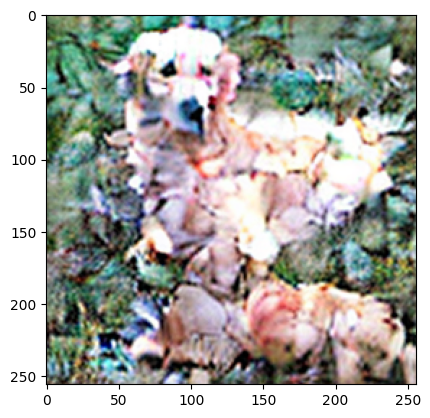

In [ ]:
# prompt: visualize last image

from PIL import Image
import matplotlib.pyplot as plt

# Load the last image from the saved tensor
last_image_tensor = torch.clamp((torch.load("dit_decoded_intermediate_samples.pt")[-50][0] + 1) * 127.5, 0, 255)

# Convert the tensor to a PIL Image
last_image = Image.fromarray(last_image_tensor.permute(1, 2, 0).cpu().numpy().astype('uint8'))

# Display the image using matplotlib
plt.imshow(last_image)
plt.show()


# SiT

In [1]:
# !git clone https://github.com/willisma/SiT.git
import SiT, os
os.chdir('SiT')
os.environ['PYTHONPATH'] = '/env/python:/content/SiT'
# !pip install diffusers timm torchdiffeq --upgrade
# SiT imports:
import torch
from torchvision.utils import save_image
from transport import create_transport, Sampler
from diffusers.models import AutoencoderKL
from download import find_model
from models import SiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

In [2]:
image_size = "256"
vae_model = "stabilityai/sd-vae-ft-ema"
latent_size = int(image_size) // 8
# Load model:
model = SiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"SiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

/content/SiT/download.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(local_path, map_location=lambda storage, loc: storage)
/usr/local/lib/python3.1

<ipython-input-3-8ed1f12114fd>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z = torch.load("starting_noise.pt")[0].unsqueeze(0)


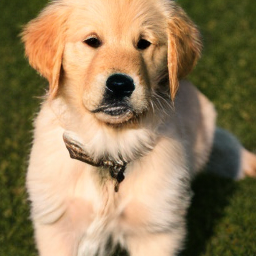

In [3]:
seed = 0
torch.manual_seed(seed)
num_sampling_steps = 250
cfg_scale = 4
class_labels = [207]
samples_per_row = 1
sampler_type = "ODE"


# Create diffusion object:
transport = create_transport()
sampler = Sampler(transport)

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
z = torch.load("starting_noise.pt")[0].unsqueeze(0)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler"
    diffusion_form = "linear"
    diffusion_norm = 1
    last_step = "Mean"
    last_step_size = 0.4
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form,
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size,
        num_steps=num_sampling_steps,
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5"
    atol = 1e-6
    rtol = 1e-3
    sample_fn = sampler.sample_ode(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps
    )
intermediate_samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[:, :1]
samples = intermediate_samples[-1]
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row),
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [30]:
# prompt: zip folder DiT

!zip -r /content/DiT.zip /content/DiT

  adding: content/DiT/ (stored 0%)
  adding: content/DiT/models.py (deflated 73%)
  adding: content/DiT/dit_epsilons.pt (deflated 6%)
  adding: content/DiT/train.py (deflated 65%)
  adding: content/DiT/__pycache__/ (stored 0%)
  adding: content/DiT/__pycache__/download.cpython-310.pyc (deflated 42%)
  adding: content/DiT/__pycache__/models.cpython-310.pyc (deflated 54%)
  adding: content/DiT/sample_ddp.py (deflated 62%)
  adding: content/DiT/CODE_OF_CONDUCT.md (deflated 56%)
  adding: content/DiT/dit_velocities.pt (deflated 99%)
  adding: content/DiT/dit_intermediate_samples.pt (deflated 6%)
  adding: content/DiT/sample.png (deflated 0%)
  adding: content/DiT/pretrained_models/ (stored 0%)
  adding: content/DiT/pretrained_models/DiT-XL-2-256x256.pt (deflated 7%)
  adding: content/DiT/sample.py (deflated 59%)
  adding: content/DiT/starting_noise.pt (deflated 53%)
  adding: content/DiT/run_DiT.ipynb (deflated 60%)
  adding: content/DiT/README.md (deflated 59%)
  adding: content/DiT/visua

In [17]:
velocities = torch.stack([v[:1] for v in sampler._ode.velocities.values()])
torch.save(
    velocities,
    'sit_velocities.pt'
)

In [ ]:
torch.save(intermediate_samples, 'intermediate_samples.pt')

In [ ]:
# prompt: for all 250 steps in intermediate steps, vae decode them and put them in a tensor. save the result to disk

import torch
from torchvision.utils import save_image

decoded_samples = []
for i, step_samples in enumerate(intermediate_samples):
#   print(i)
  decoded_step_samples = vae.decode(step_samples / 0.18215).sample
  decoded_samples.append(decoded_step_samples)

# Convert the list of decoded samples to a tensor
decoded_samples_tensor = torch.stack(decoded_samples)

# Save the tensor to disk
torch.save(decoded_samples_tensor, "sit_decoded_intermediate_samples.pt")

<ipython-input-24-8a58a782ef85>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  last_image_tensor = torch.clamp((torch.load("decoded_intermediate_samples.pt")[-50][0] + 1) 

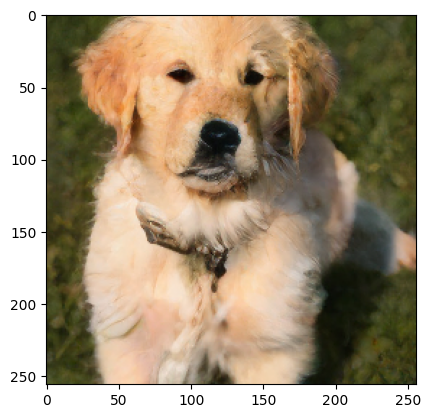

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the last image from the saved tensor
last_image_tensor = torch.clamp((torch.load("sit_decoded_intermediate_samples.pt")[-50][0] + 1) * 127.5, 0, 255)

# Convert the tensor to a PIL Image
last_image = Image.fromarray(last_image_tensor.permute(1, 2, 0).cpu().numpy().astype('uint8'))

# Display the image using matplotlib
plt.imshow(last_image)
plt.show()
